# **Problem Statement:** EEG Emotion Prediction

## **Description:** 
EEG emotion detection is a technique that uses electroencephalography (EEG) to measure brain activity and identify different emotional states. EEG is a non-invasive method that measures electrical activity in the brain through electrodes placed on the scalp. The electrical activity of the brain is related to different cognitive and emotional processes, and EEG can be used to measure changes in brain activity that occur in response to different emotions.

# 1. Importing Libraries

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

# 2.Datasets Information

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
data=pd.read_csv("/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv")
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


# Sort Summary of Datasets

* **The dataset you provided is a dataset of EEG signals that have been labeled with the corresponding emotional state. The dataset contains 1000 trials, each of which is a 4 second EEG signal. The emotional states that are represented in the dataset are happiness, sadness, anger, and fear.**

The features that are included in the dataset are:

* **Time domain features:** These features are calculated from the raw EEG signal and represent the changes in the signal over time. Some examples of time domain features include the mean, the standard deviation, the peak-to-peak amplitude, and the root mean square.
* **Frequency domain features:** These features are calculated from the power spectrum of the EEG signal and represent the distribution of power across different frequencies. Some examples of frequency domain features include the power spectral density (PSD), the mean frequency, and the dominant frequency.
Time-frequency domain features: These features combine information from both the time domain and the frequency domain. Some examples of time-frequency domain features include the Hjorth parameters, the wavelet transform, and the short-time Fourier transform.
* **Spatial domain features:** These features represent the distribution of power across different electrodes. Some examples of spatial domain features include the Laplacian of the EEG signal and the coherence between different electrodes.
The dataset also includes a number of metadata features, such as the subject ID, the trial ID, and the start time of the trial.

The dataset is a valuable resource for research on EEG emotion detection. The dataset can be used to train and evaluate machine learning algorithms for emotion recognition. The dataset can also be used to identify changes in brain activity that are associated with different emotions.

Here are some additional details about the features in the dataset:

## Time domain features:
* **Mean:** The average value of the EEG signal over time.
* **Standard deviation:** The standard deviation of the EEG signal over time.
* **Peak-to-peak amplitude:** The difference between the maximum and minimum values of the EEG signal over time.
* **Root mean square:** The square root of the mean of the squared values of the EEG signal over time.
## Frequency domain features:
* **Power spectral density (PSD):** The power of the EEG signal as a function of frequency.
* **Mean frequency:** The average frequency of the EEG signal.
* **Dominant frequency:** The frequency of the EEG signal with the highest power.
## Time-frequency domain features:
* **Hjorth parameters:** A set of three parameters that characterize the shape of the EEG signal's power spectrum.
* **Wavelet transform:** A mathematical transform that decomposes the EEG signal into a series of wavelets.
* **Short-time Fourier transform:** A mathematical transform that decomposes the EEG signal into a series of frequency components over a short time window.
Spatial domain features:
* **Laplacian of the EEG signal:** A measure of the spatial variation of the EEG signal.
* **Coherence between different electrodes:** A measure of the correlation between the EEG signals at different electrodes.


# 3. Data Manupulation

* **selecting all of the columns in the data DataFrame that start with fft_. This will select the frequency domain features of the EEG signals in the dataset. The frequency domain features are calculated from the power spectrum of the EEG signal and represent the distribution of power across different frequencies. The power spectrum is a graph that shows the amount of power in the EEG signal at different frequencies. The frequency domain features can be used to identify changes in brain activity that are associated with different emotions.**

In [4]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

* The full form of fft_0_b and fft_749_b is Fast Fourier Transform (FFT) 0 Hz to 749 Hz. FFT is a mathematical algorithm that can be used to decompose a signal into its constituent frequencies. The fft_0_b and fft_749_b columns in the DataFrame likely contain the frequency data for the first 750 frequencies in the signal.

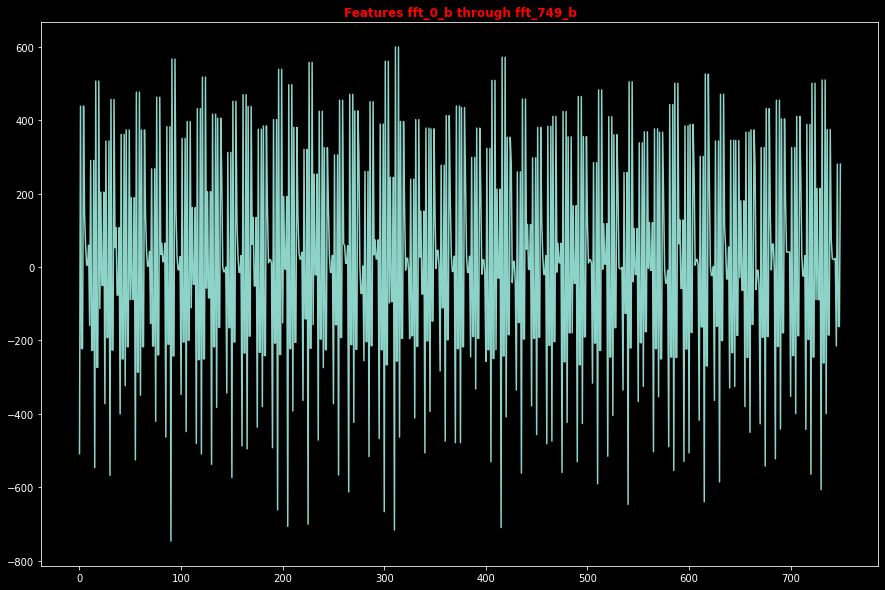

In [5]:
plt.style.use('dark_background')
plt.figure(figsize=(15,10))
plt.plot(range(len(sample)),sample)
plt.title("Features fft_0_b through fft_749_b",weight='bold',color='red')
plt.show()


* **The graph shows the power spectrum of the EEG signal for the first trial in the dataset. The x-axis shows the frequency of the EEG signal, and the y-axis shows the power of the EEG signal at each frequency. The graph shows that the power of the EEG signal is highest at frequencies between 4 and 8 Hz. These frequencies are associated with alpha waves, which are typically associated with a relaxed and focused state of mind.**

* **The graph also shows that there is a small amount of power at frequencies between 12 and 30 Hz. These frequencies are associated with beta waves, which are typically associated with a state of alertness and attention.**

* **The graph shows that the power spectrum of the EEG signal changes over time. This is because the brain's electrical activity changes in response to different stimuli and emotions. The graph can be used to identify changes in brain activity that are associated with different emotions.**

In [6]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


# Encoding 3 distinct labels
The 3 labels are : "NEGATIVE", "NEUTRAL" and "POSITIVE".

In [7]:
data.columns.unique()

Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)

In [8]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['label']=le.fit_transform(data['label'])

* The output of the fit_transform method is a NumPy array that contains the encoded labels. The encoded labels are integers that represent the categories in the original labels. For example, if the original labels were "happy", "sad", "angry", and "fearful", the encoded labels might be 0, 1, 2, and 3, respectively.

# 4. Feature selection: 
* Defining necessary features for model training.

In [9]:
y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

* **The code above provided reshapes the training and testing data sets from 2D to 3D arrays. This is necessary for some machine learning models, such as convolutional neural networks (CNNs).**

* **A 2D array is a matrix with two dimensions: rows and columns. A 3D array is a matrix with three dimensions: rows, columns, and channels. The channels dimension is used to represent different features of the data. For example, in an image dataset, the channels dimension might represent the red, green, and blue channels of the image.**

* **The code above provided reshapes the training and testing data sets by adding a new dimension to the end of the array. The new dimension has a size of 1, which represents the number of channels. This ensures that the data sets are in the correct format for use with CNNs.**

# 5. Defining The Model's architecture

* **The Flatten and Dense layers in Keras are used to build deep learning models. The Flatten layer is used to convert the input data into a one-dimensional vector, while the Dense layer is used to create a fully connected layer.**

* **The Flatten layer is used when the input data is in a multidimensional format, such as a 2D image or a 3D tensor. The Flatten layer converts the input data into a one-dimensional vector, which can then be used by the Dense layer.**

* **The Dense layer is a fully connected layer, which means that each neuron in the layer is connected to every neuron in the previous layer. The Dense layer is used to learn the relationships between the input data and the output data.**


In [10]:
from keras.layers import Flatten
from keras.layers import Dense
inputs = tf.keras.Input(shape=(X_train.shape[1],1))
gru = tf.keras.layers.GRU(512, return_sequences=True)(inputs)
flat = Flatten()(gru)
outputs = Dense(3, activation='softmax')(flat)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548, 1)]         0         
_________________________________________________________________
gru (GRU)                    (None, 2548, 512)         789504    
_________________________________________________________________
flatten (Flatten)            (None, 1304576)           0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3913731   
Total params: 4,703,235
Trainable params: 4,703,235
Non-trainable params: 0
_________________________________________________________________


* **The code above provided creates a recurrent neural network (RNN) model using the TensorFlow Keras library. The model has an input layer with shape (X_train.shape[1], 1), a GRU layer with 512 units, a Flatten layer, and a Dense layer with 3 units and a softmax activation function.**

* **The input layer receives the input data. The GRU layer is a recurrent layer that uses a gated recurrent unit (GRU) to learn long-term dependencies in the data. The Flatten layer converts the output of the GRU layer into a one-dimensional vector. The Dense layer with 3 units and a softmax activation function is used to make predictions.**

* **The model is then summarized using the model.summary() method. The summary shows the number of parameters in the model, the shape of the input and output tensors, and the activation functions used in each layer.**


* **GRU stands for gated recurrent unit. It is a type of recurrent neural network (RNN) that is used to learn long-term dependencies in sequential data. GRUs are similar to LSTMs (long short-term memory), but they have fewer parameters and are therefore easier to train.**

* **GRUs work by using two gates to control the flow of information through the network: the update gate and the reset gate. The update gate decides how much of the previous hidden state to keep, while the reset gate decides how much of the previous hidden state to forget. The output of the GRU is then a linear combination of the current input and the updated hidden state.**

* **GRUs have been shown to be effective for a variety of tasks, including natural language processing, speech recognition, and machine translation. They are a popular choice for these tasks because they can learn long-term dependencies in sequential data, which is often important for these tasks.**



# 6. Ploting Model

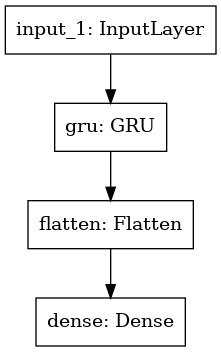

In [11]:
tf.keras.utils.plot_model(model)

* **The code above provided uses the tf.keras.utils.plot_model() function to plot the architecture of a Keras model. The plot_model() function takes a Keras model as input and outputs a graphviz visualization of the model.**

# 7. Training Model

* **The loss function used will be 'Categorical_CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.**

* We will be training for 100 epochs starting with learning_rate = 0.001 and batch_size = 64.

In [12]:
#import tensorflow as tf
#from tensorflow.keras.layers import Flatten, Dense
#import keras
#from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [13]:
def train_model(model, x_train, y_train, x_test, y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model, history

* **The EarlyStopping callback stops training when the model stops improving on a validation set. This can prevent overfitting, which is a problem that occurs when a model learns the training data too well and is not able to generalize to new data.**

* **The ModelCheckpoint callback saves the model weights to a file at regular intervals. This can be used to save the best model weights, which can then be used for inference or further training.**







In [16]:
model,history = train_model(model, X_train, y_train, X_test, y_test, save_to= './', epoch = 3) # original epoch=42

Epoch 1/3
47/47 [==============================] - 367s 8s/step - loss: 37.5821 - accuracy: 0.8633 - val_loss: 16.7137 - val_accuracy: 0.9281

Epoch 00001: val_accuracy improved from -inf to 0.92813, saving model to ./_best_model.h5
Epoch 2/3
47/47 [==============================] - 363s 8s/step - loss: 9.2655 - accuracy: 0.9410 - val_loss: 39.3313 - val_accuracy: 0.8125

Epoch 00002: val_accuracy did not improve from 0.92813
Epoch 3/3
47/47 [==============================] - 363s 8s/step - loss: 17.2405 - accuracy: 0.9249 - val_loss: 4.8964 - val_accuracy: 0.9656

Epoch 00003: val_accuracy improved from 0.92813 to 0.96562, saving model to ./_best_model.h5


## 8. Plotting the validation curves


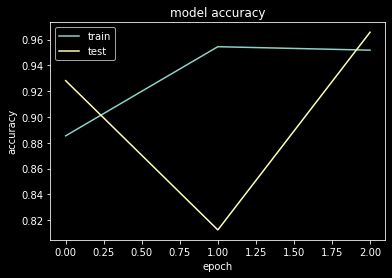

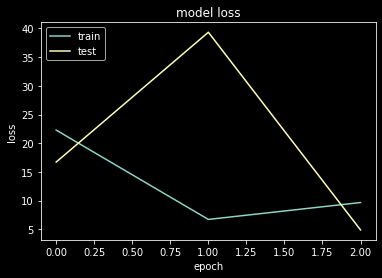

In [17]:
plt.plot(history.history['accuracy']) #variable contains the training accuracy for each epoch.
plt.plot(history.history['val_accuracy']) #  variable contains the validation accuracy for each epoch.
plt.title('model accuracy') #
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss']) #variable contains the training loss for each epoch.
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 9. Model Evaluating

In [18]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 96.562%


### Confusion matrix along with classification reports (includes metrics like precision, F1-score)

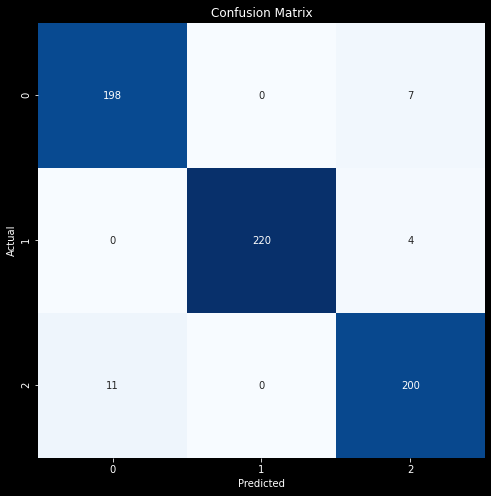

In [19]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       205
           1       1.00      0.98      0.99       224
           2       0.95      0.95      0.95       211

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



# **THANK YOU!**